<a href="https://colab.research.google.com/github/EliasEconomou/DataMining2-Travel-Time-Prediction/blob/main/DataMining2_Travel_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Files**

In [75]:
import numpy as np
import pandas as pd
import sys
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cityblock
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [76]:
# Options
pd.options.mode.chained_assignment = None


In [77]:
# Read data files
def read_file(filePath):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath)
  return rFile

In [78]:
# Reading train/test/target data files
trainFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/train.csv"
testFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/test.csv"
targetFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/target.csv"


In [79]:
train = read_file(trainFilePath)
test = read_file(testFilePath)
target = read_file(targetFilePath)

train.dropna(inplace = True)
test.dropna(inplace = True)
target.dropna(inplace = True)

print(train.shape,test.shape,target.shape)

(1166915, 11) (291729, 9) (291729, 2)


In [80]:
# Choose a subset - percentage of the dataset's rows
def select_dfsubset(initDF, percentage):
  numOfRows = initDF.shape[0]
  newDF = initDF.iloc[:int(percentage*0.01*numOfRows)]
  return newDF

# **Analyzing Data**


> Here we start by cleaning the dataset from any outliers. Then we analyze it to extract some useful info regarding travels in NY. We explore busiest days, hours, how travel time gets affected by different vendors or the number of passenger, how different time of day may impact drivers' speed and many more.


In [81]:
# We can choose a subset of our train-test dataset to analyze
percentage = 100
trainDF = select_dfsubset(train,percentage)
print("Chosen number of travels is {} - {}% of the given train-dataset.".format(trainDF.shape[0], percentage))
testDF = select_dfsubset(test,percentage)
print("Chosen number of travels is {} - {}% of the given test-dataset.".format(testDF.shape[0], percentage))

Chosen number of travels is 1166915 - 100% of the given train-dataset.
Chosen number of travels is 291729 - 100% of the given test-dataset.


##*1. Removing outliers*

In [82]:
# Getting some basic statistics of out dataset with trip duration outliers
statistics = trainDF.describe()
tripDurMean = statistics["trip_duration"]["mean"]
tripDurStd = statistics["trip_duration"]["std"]
statistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06
mean,1.534915e+00,1.665292e+00,-7.397346e+01,4.075089e+01,-7.397340e+01,4.075182e+01,9.584392e+02
std,4.987797e-01,1.314746e+00,6.231408e-02,3.173031e-02,6.157028e-02,3.645646e-02,5.334345e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073731e+01,-7.399133e+01,4.073591e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075407e+01,-7.397977e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [83]:
# Trip duration outlier is considered to be every value 2 standard deviations
# away from the mean
upperOutlier = tripDurMean+2*tripDurStd
lowerOutlier = tripDurMean-2*tripDurStd

is_outlier = np.where((trainDF.trip_duration >= upperOutlier) | (trainDF.trip_duration <= lowerOutlier),"outlier","inlier")
isOutlier = list(is_outlier)
print("Number of outliers is {}.".format(isOutlier.count("outlier")))


Number of outliers is 1665.


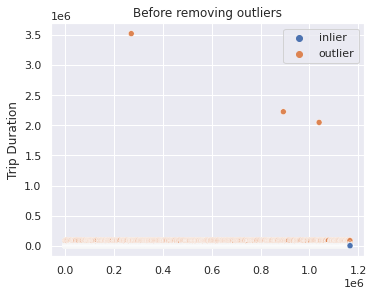

In [84]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=is_outlier).set(title="Before removing outliers",
                                                       ylabel = "Trip Duration")


In [85]:
# Now let's remove all rows with trip duration outliers
trainDF = trainDF.drop(trainDF[trainDF.trip_duration > upperOutlier].index)
trainDF = trainDF.drop(trainDF[trainDF.trip_duration < lowerOutlier].index)

# Print the new statistics
newStatistics = trainDF.describe()
newTripDurMean = newStatistics["trip_duration"]["mean"]
newTripDurStd = newStatistics["trip_duration"]["std"]
newStatistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06
mean,1.534260e+00,1.664723e+00,-7.397346e+01,4.075090e+01,-7.397340e+01,4.075182e+01,8.370149e+02
std,4.988251e-01,1.314119e+00,6.230739e-02,3.170862e-02,6.159180e-02,3.645359e-02,6.590678e+02
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073732e+01,-7.399133e+01,4.073592e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075408e+01,-7.397977e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076835e+01,-7.396303e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,1.155600e+04


In [86]:
# Compute new outliers
newUpperOutlier = tripDurMean+2*tripDurStd
newLowerOutlier = tripDurMean-2*tripDurStd

new_is_outlier = np.where((trainDF.trip_duration >= newUpperOutlier) | (trainDF.trip_duration <= newLowerOutlier),"outlier","inlier")

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


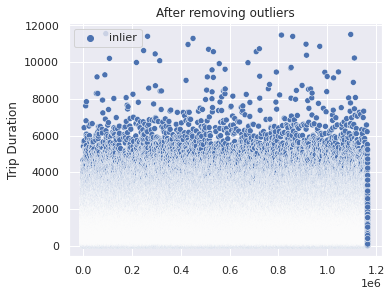

In [87]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=new_is_outlier).set(title="After removing outliers",
                                                       ylabel = "Trip Duration")

##*2. Remove any points outside NY*

In [88]:
# NY longitude border is (-74.03, -73.75) and latitude border is (40.63, 40.85)
# Keep borders
minLongBorder = -74.03
maxLongBorder = -73.75
minLatBorder = 40.63
maxLatBorder = 40.85

# Minimum and maximum values before removal
min_pickupLong = min(trainDF.pickup_longitude)
max_pickupLong = max(trainDF.pickup_longitude)
min_dropoffLong = min(trainDF.dropoff_longitude)
max_dropoffLong = max(trainDF.dropoff_longitude)

min_pickupLat = min(trainDF.pickup_latitude)
max_pickupLat = max(trainDF.pickup_latitude)
min_dropoffLat = min(trainDF.dropoff_latitude)
max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(1165250, 11)

In [89]:
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude > maxLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude > maxLongBorder].index)

trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude > maxLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude > maxLatBorder].index)


In [90]:
# Minimum and maximum values after removal
new_min_pickupLong = min(trainDF.pickup_longitude)
new_max_pickupLong = max(trainDF.pickup_longitude)
new_min_dropoffLong = min(trainDF.dropoff_longitude)
new_max_dropoffLong = max(trainDF.dropoff_longitude)

new_min_pickupLat = min(trainDF.pickup_latitude)
new_max_pickupLat = max(trainDF.pickup_latitude)
new_min_dropoffLat = min(trainDF.dropoff_latitude)
new_max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(1149734, 11)

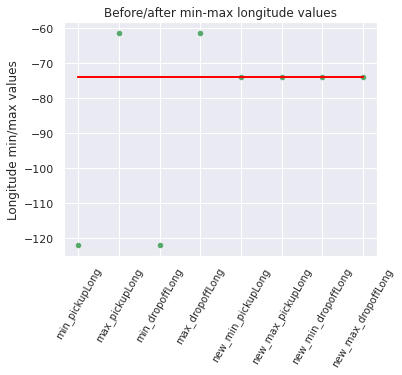

In [91]:
# Now lets plot before/after min-max longitude values
x_coordinates = ["min_pickupLong", "max_pickupLong", "min_dropoffLong", 
                 "max_dropoffLong", "new_min_pickupLong", "new_max_pickupLong",
                 "new_min_dropoffLong", "new_max_dropoffLong"]
y_coordinates = [min_pickupLong, max_pickupLong, min_dropoffLong,
                 max_dropoffLong, new_min_pickupLong, new_max_pickupLong,
                 new_min_dropoffLong, new_max_dropoffLong]

plt.scatter(x_coordinates, y_coordinates, color='g', s=20)
plt.xticks(rotation = 60, fontsize=10)
plt.ylabel('Longitude min/max values')
plt.title('Before/after min-max longitude values')
plot_long = plt.plot([0, 7], [minLongBorder, minLongBorder], linewidth=2, color="red")
plot_long = plt.plot([0, 7], [maxLongBorder, maxLongBorder], linewidth=2, color="red")


The red lines represent the longitude limits of NY. The minimum/maximum values surpassed these limits, but after cleaning the new values are within the borders thus we only kept travels strictly inside NY. Same applies for latitude.

##*3. Date time analysis*

### Preprocessing

In [92]:
# Convert date string to timestamp for both train and test datasets
trainDF["pickup_datetime"] =  pd.to_datetime(trainDF["pickup_datetime"], infer_datetime_format=True)
trainDF["dropoff_datetime"] =  pd.to_datetime(trainDF["dropoff_datetime"], infer_datetime_format=True)
testDF["pickup_datetime"] =  pd.to_datetime(testDF["pickup_datetime"], infer_datetime_format=True)

In [93]:
# We 'll use these functions to create a few time related columns

def create_day_period(datetime):
  if (datetime.hour >= 6) & (datetime.hour <= 11):
    return "Morning"
  elif (datetime.hour >= 12) & (datetime.hour <= 15):
    return "Afternoon"
  elif (datetime.hour >= 16) & (datetime.hour <= 21):
    return "Evening"
  else:
    return "Late Night"

def create_day_name(datetime):
  return datetime.day_name()

def create_month(datetime):
  if (datetime.month == 1):
    return "January"
  elif (datetime.month == 2):
    return "February"
  elif (datetime.month == 3):
    return "March"
  elif (datetime.month == 4):
    return "April"
  elif (datetime.month == 5):
    return "May"
  elif (datetime.month == 6):
    return "June"
  elif (datetime.month == 7):
    return "July"
  elif (datetime.month == 8):
    return "August"
  elif (datetime.month == 9):
    return "September"
  elif (datetime.month == 10):
    return "Octomber"
  elif (datetime.month == 11):
    return "November"
  elif (datetime.month == 12):
    return "December"
  return datetime.month

def create_hour(datetime):
  return datetime.hour

def create_year(datetime):
  return datetime.year

def create_season(datetime):
  if (datetime.month >= 3) & (datetime.month <= 5):
    return "Spring"
  if (datetime.month >= 6) & (datetime.month <= 8):
    return "Summer"
  if (datetime.month >= 9) & (datetime.month <= 11):
    return "Autumn"
  else:
    return "Winter"


In [94]:
# Adding day period columns
trainDF["pickup_day_period"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))
trainDF["dropoff_day_period"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_period(datetime))
testDF["pickup_day_period"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))

# Adding day name columns
trainDF["pickup_day_name"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))
trainDF["dropoff_day_name"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_name(datetime))
testDF["pickup_day_name"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))

# Adding month columns
trainDF["pickup_month"] = trainDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))
trainDF["dropoff_month"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_month(datetime))
testDF["pickup_month"] = testDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))

# Adding hour columns
trainDF["pickup_hour"] = trainDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))
trainDF["dropoff_hour"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_hour(datetime))
testDF["pickup_hour"] = testDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))

# Adding year columns
trainDF["pickup_year"] = trainDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))
trainDF["dropoff_year"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_year(datetime))
testDF["pickup_year"] = testDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))


# Adding season columns
trainDF["pickup_season"] = trainDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))
trainDF["dropoff_season"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_season(datetime))
testDF["pickup_season"] = testDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))


### Most busy pickup days

In [95]:
sns.set(rc={'figure.figsize':(10,4)})

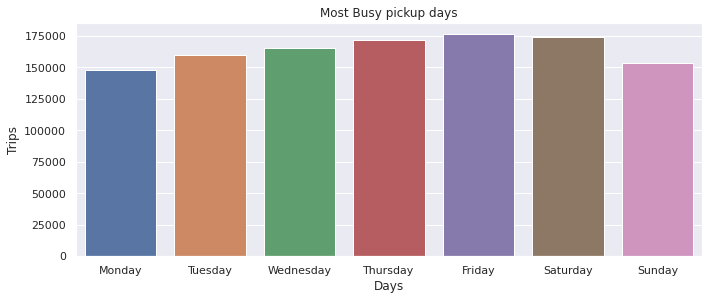

In [96]:
pDaysDict = {}
pDaysDict['Monday'] = trainDF[trainDF.pickup_day_name == "Monday"].shape[0]
pDaysDict['Tuesday'] = trainDF[trainDF.pickup_day_name == "Tuesday"].shape[0]
pDaysDict['Wednesday'] = trainDF[trainDF.pickup_day_name == "Wednesday"].shape[0]
pDaysDict['Thursday'] = trainDF[trainDF.pickup_day_name == "Thursday"].shape[0]
pDaysDict['Friday'] = trainDF[trainDF.pickup_day_name == "Friday"].shape[0]
pDaysDict['Saturday'] = trainDF[trainDF.pickup_day_name == "Saturday"].shape[0]
pDaysDict['Sunday'] = trainDF[trainDF.pickup_day_name == "Sunday"].shape[0]



busypDaysPlot = sns.barplot(x=list(pDaysDict.keys()),
                           y=list(pDaysDict.values())).set(title='Most Busy pickup days')

plt.xlabel("Days")
plt.ylabel("Trips")

plt.show(busypDaysPlot)


### Most busy dropoff days

In [97]:
sns.set(rc={'figure.figsize':(10,4)})

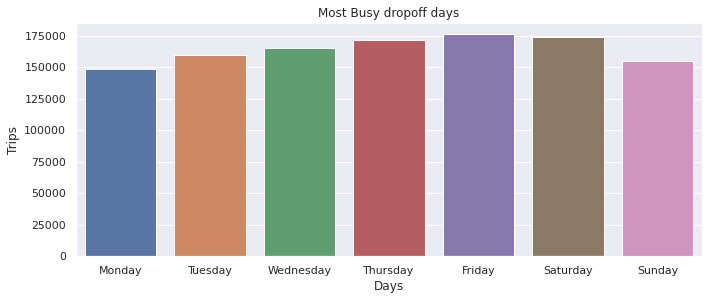

In [98]:
dDaysDict = {}
dDaysDict['Monday'] = trainDF[trainDF.dropoff_day_name == "Monday"].shape[0]
dDaysDict['Tuesday'] = trainDF[trainDF.dropoff_day_name == "Tuesday"].shape[0]
dDaysDict['Wednesday'] = trainDF[trainDF.dropoff_day_name == "Wednesday"].shape[0]
dDaysDict['Thursday'] = trainDF[trainDF.dropoff_day_name == "Thursday"].shape[0]
dDaysDict['Friday'] = trainDF[trainDF.dropoff_day_name == "Friday"].shape[0]
dDaysDict['Saturday'] = trainDF[trainDF.dropoff_day_name == "Saturday"].shape[0]
dDaysDict['Sunday'] = trainDF[trainDF.dropoff_day_name == "Sunday"].shape[0]



busydDaysPlot = sns.barplot(x=list(dDaysDict.keys()),
                           y=list(dDaysDict.values())).set(title='Most Busy dropoff days')

plt.xlabel("Days")
plt.ylabel("Trips")

plt.show(busydDaysPlot)


### Trips per day period

In [99]:
sns.set(rc={'figure.figsize':(12,4)})

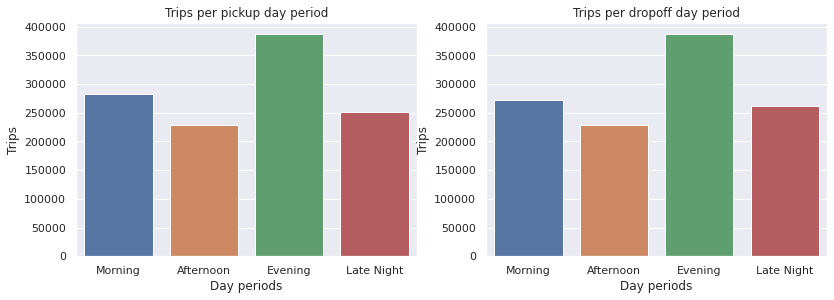

In [100]:
pDayPeriodDict = {}
pDayPeriodDict['Morning'] = trainDF[trainDF.pickup_day_period == "Morning"].shape[0]
pDayPeriodDict['Afternoon'] = trainDF[trainDF.pickup_day_period == "Afternoon"].shape[0]
pDayPeriodDict['Evening'] = trainDF[trainDF.pickup_day_period == "Evening"].shape[0]
pDayPeriodDict['Late Night'] = trainDF[trainDF.pickup_day_period == "Late Night"].shape[0]

dDayPeriodDict = {}
dDayPeriodDict['Morning'] = trainDF[trainDF.dropoff_day_period == "Morning"].shape[0]
dDayPeriodDict['Afternoon'] = trainDF[trainDF.dropoff_day_period == "Afternoon"].shape[0]
dDayPeriodDict['Evening'] = trainDF[trainDF.dropoff_day_period == "Evening"].shape[0]
dDayPeriodDict['Late Night'] = trainDF[trainDF.dropoff_day_period == "Late Night"].shape[0]

fig, ax = plt.subplots(1,2)
pDayPeriodPlot = sns.barplot(x=list(pDayPeriodDict.keys()),
                             y=list(pDayPeriodDict.values()),
                             ax=ax[0]).set(title='Trips per pickup day period')
dDayPeriodPlot = sns.barplot(x=list(dDayPeriodDict.keys()),
                             y=list(dDayPeriodDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff day period')

for ax in fig.axes:
  plt.sca(ax)
  plt.xlabel("Day periods")
  plt.ylabel("Trips")

fig.show()

### Trips per month

In [101]:
sns.set(rc={'figure.figsize':(12,4)})


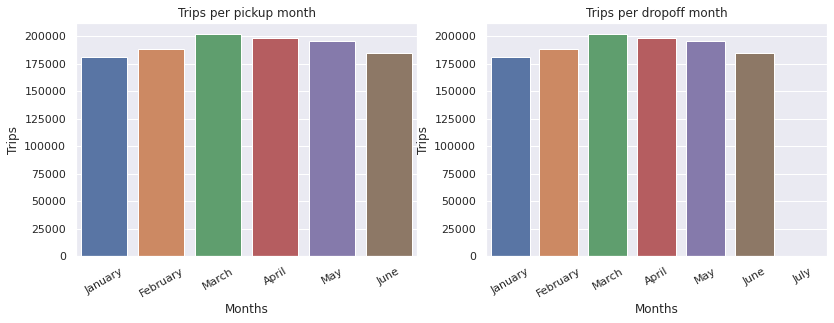

In [102]:
pMonthDict = {}
pMonthDict['January'] = 0
pMonthDict['February'] = 0
pMonthDict['March'] = 0
pMonthDict['April'] = 0
pMonthDict['May'] = 0
pMonthDict['June'] = 0
pMonthDict['July'] = 0
pMonthDict['August'] = 0
pMonthDict['September'] = 0
pMonthDict['Octomber'] = 0
pMonthDict['November'] = 0
pMonthDict['December'] = 0

ptempDict = dict(trainDF['pickup_month'].value_counts())
pMonthDict.update(ptempDict)
pMonthDict = {k: v for k, v in pMonthDict.items() if v!=0}


dMonthDict = {}
dMonthDict['January'] = 0
dMonthDict['February'] = 0
dMonthDict['March'] = 0
dMonthDict['April'] = 0
dMonthDict['May'] = 0
dMonthDict['June'] = 0
dMonthDict['July'] = 0
dMonthDict['August'] = 0
dMonthDict['September'] = 0
dMonthDict['Octomber'] = 0
dMonthDict['November'] = 0
dMonthDict['December'] = 0

dtempDict = dict(trainDF['dropoff_month'].value_counts())
dMonthDict.update(dtempDict)
dMonthDict = {k: v for k, v in dMonthDict.items() if v!=0}

fig, ax = plt.subplots(1,2)

pMonthPlot = sns.barplot(x=list(pMonthDict.keys()),
                             y=list(pMonthDict.values()),
                             ax=ax[0]).set(title='Trips per pickup month')

dMonthPlot = sns.barplot(x=list(dMonthDict.keys()),
                             y=list(dMonthDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff month')


for ax in fig.axes:
  plt.sca(ax)
  plt.xticks(rotation=30)
  plt.xlabel("Months")
  plt.ylabel("Trips")

fig.show()

### Average travel time by pickup hour

In [103]:
sns.set(rc={'figure.figsize':(11,4)})


In [104]:
groupedPickupHours = trainDF.groupby(["pickup_hour"])
avgPickupHours = dict(groupedPickupHours["trip_duration"].mean())

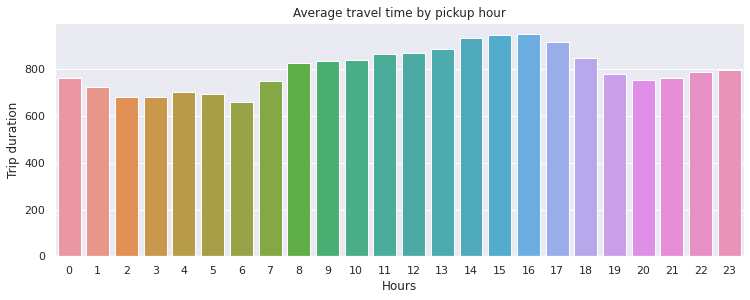

In [105]:
pickupHourPlot = sns.barplot(x=list(avgPickupHours.keys()),
                           y=list(avgPickupHours.values())).set(title='Average travel time by pickup hour')

plt.xlabel("Hours")
plt.ylabel("Trip duration")
plt.show(pickupHourPlot)

### Average travel time by day period

In [106]:
avgDayPeriods = {}
avgDayPeriods['Morning'] = 0
avgDayPeriods['Afternoon'] = 0
avgDayPeriods['Evening'] = 0
avgDayPeriods['Late Night'] = 0

groupedDayPeriods = trainDF.groupby(["pickup_day_period"])
tempAvgDayPeriods = dict(groupedDayPeriods["trip_duration"].mean())
avgDayPeriods.update(tempAvgDayPeriods)

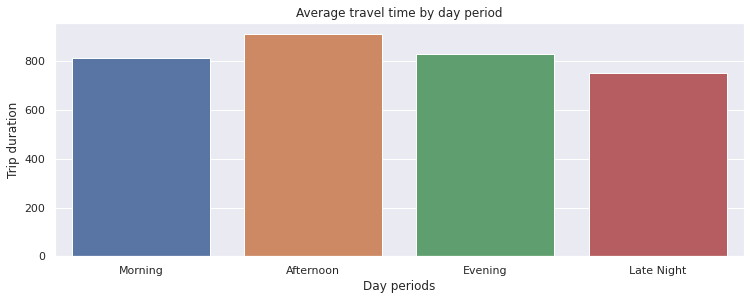

In [107]:
dayPeriodPlot = sns.barplot(x=list(avgDayPeriods.keys()),
                           y=list(avgDayPeriods.values())).set(title='Average travel time by day period')

plt.xlabel("Day periods")
plt.ylabel("Trip duration")
plt.show(dayPeriodPlot)

### Average travel time by day of week

In [108]:
avgDays = {}
avgDays['Monday'] = 0
avgDays['Tuesday'] = 0
avgDays['Wednesday'] = 0
avgDays['Thursday'] = 0
avgDays['Friday'] = 0
avgDays['Saturday'] = 0
avgDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgDays = dict(groupedDays["trip_duration"].mean())
avgDays.update(tempAvgDays)

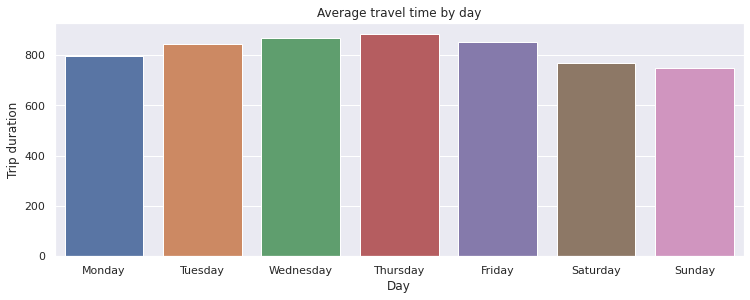

In [109]:
daysPlot = sns.barplot(x=list(avgDays.keys()),
                           y=list(avgDays.values())).set(title='Average travel time by day')

plt.xlabel("Day")
plt.ylabel("Trip duration")
plt.show(daysPlot)

##*4. Trip duration log transformation*

In [110]:
sns.set(rc={'figure.figsize':(10,4)})


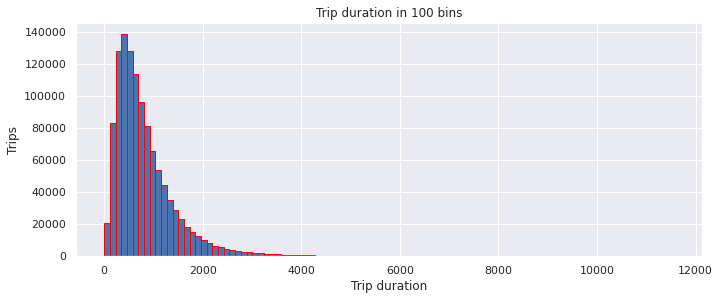

In [111]:
tripDurPlot = plt.hist(trainDF.trip_duration, edgecolor="red", bins=100)
plt.xlabel("Trip duration")
plt.ylabel("Trips")
plt.title("Trip duration in 100 bins")
plt.show()

In [112]:
trainDF["log_trip_duration"] = np.log(trainDF["trip_duration"])

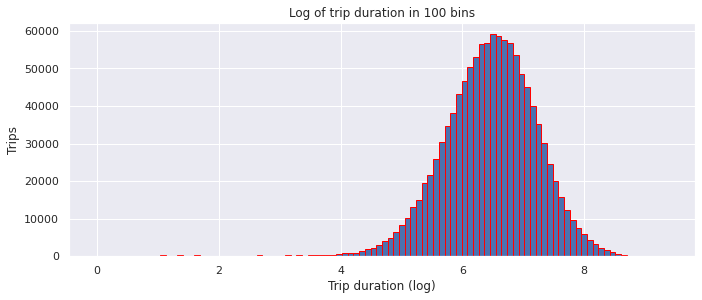

In [113]:
tripLogDurPlot = plt.hist(trainDF.log_trip_duration, edgecolor="red", bins=100)
plt.xlabel("Trip duration (log)")
plt.ylabel("Trips")
plt.title("Log of trip duration in 100 bins")
plt.show()

##*5. Average travel time by vendor*

In [114]:
sns.set(rc={'figure.figsize':(4,4)})


In [115]:
groupedVendors = trainDF.groupby(["vendor_id"])
avgVendors = dict(groupedVendors["trip_duration"].mean())

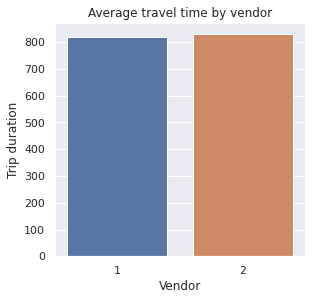

In [116]:
vendorPlot = sns.barplot(x=list(avgVendors.keys()),
                           y=list(avgVendors.values())).set(title='Average travel time by vendor')

plt.xlabel("Vendor")
plt.ylabel("Trip duration")
plt.show(vendorPlot)

##*6. Average travel time by number of passengers*

In [117]:
sns.set(rc={'figure.figsize':(9,4)})


In [118]:
groupedPassengerCount = trainDF.groupby(["passenger_count"])
avgPassengerCount = dict(groupedPassengerCount["trip_duration"].mean())

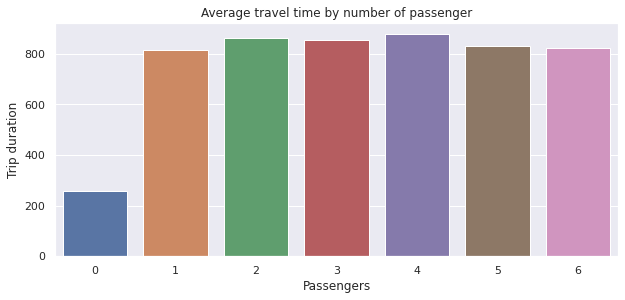

In [119]:
passengerCountPlot = sns.barplot(x=list(avgPassengerCount.keys()),
                           y=list(avgPassengerCount.values())).set(title='Average travel time by number of passenger')

plt.xlabel("Passengers")
plt.ylabel("Trip duration")
plt.show(passengerCountPlot)

##*7. Distance between points*

In [120]:
# Create a new column containing the Manhattan distance between pickup and
# dropoff points
trainDF["distance"] = trainDF.apply(lambda row: cityblock([row.pickup_longitude,row.pickup_latitude],
                                                          [row.dropoff_longitude,row.dropoff_latitude]), axis = 1)

testDF["distance"] = testDF.apply(lambda row: cityblock([row.pickup_longitude,row.pickup_latitude],
                                                          [row.dropoff_longitude,row.dropoff_latitude]), axis = 1)

### Average travel distance by day of week

In [121]:
avgTDDays = {}
avgTDDays['Monday'] = 0
avgTDDays['Tuesday'] = 0
avgTDDays['Wednesday'] = 0
avgTDDays['Thursday'] = 0
avgTDDays['Friday'] = 0
avgTDDays['Saturday'] = 0
avgTDDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgTDDays = dict(groupedDays["distance"].mean())
avgTDDays.update(tempAvgTDDays)

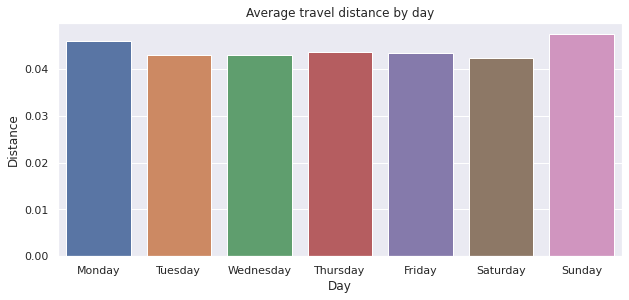

In [122]:
TDdaysPlot = sns.barplot(x=list(avgTDDays.keys()),
                           y=list(avgTDDays.values())).set(title='Average travel distance by day')

plt.xlabel("Day")
plt.ylabel("Distance")
plt.show(TDdaysPlot)

### Travel time and distance

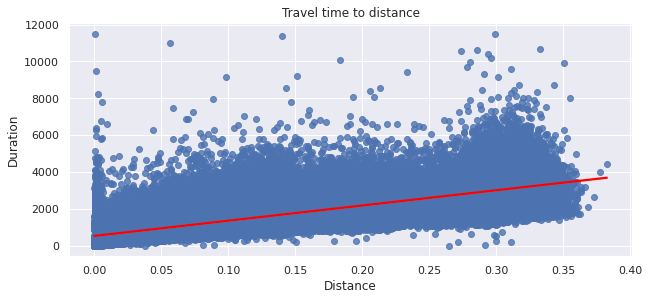

In [123]:
timeDist = dict(zip(trainDF.distance, trainDF.trip_duration))

y_values=list(timeDist.values())
x_values=list(timeDist.keys())
timeDistPlot = sns.regplot(y=y_values,
                           x=x_values,
                           line_kws={"color": "red"}).set(title="Travel time to distance",
                                                       ylabel = "Duration",
                                                       xlabel = "Distance")


##*8. Average speed*

In [124]:
trainDF["average_speed"] = trainDF["distance"]/trainDF["trip_duration"]

### Average speed by hour

In [125]:
sns.set(rc={'figure.figsize':(11,4)})


In [126]:
groupedPickupHours = trainDF.groupby(["pickup_hour"])
avgSpeedPickupHours = dict(groupedPickupHours["average_speed"].mean())

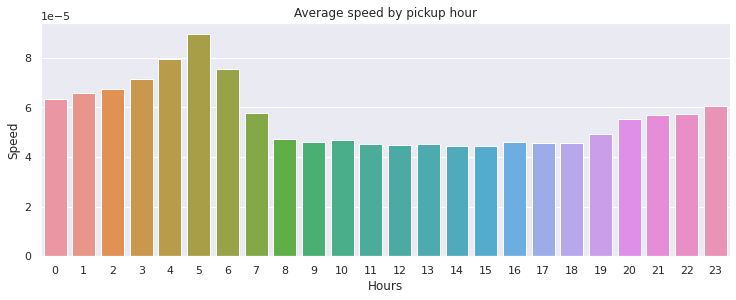

In [127]:
speedHourPlot = sns.barplot(x=list(avgSpeedPickupHours.keys()),
                           y=list(avgSpeedPickupHours.values())).set(title='Average speed by pickup hour')

plt.xlabel("Hours")
plt.ylabel("Speed")
plt.show(speedHourPlot)

### Average speed by day of week

In [128]:
avgSDays = {}
avgSDays['Monday'] = 0
avgSDays['Tuesday'] = 0
avgSDays['Wednesday'] = 0
avgSDays['Thursday'] = 0
avgSDays['Friday'] = 0
avgSDays['Saturday'] = 0
avgSDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgSDays = dict(groupedDays["average_speed"].mean())
avgSDays.update(tempAvgSDays)

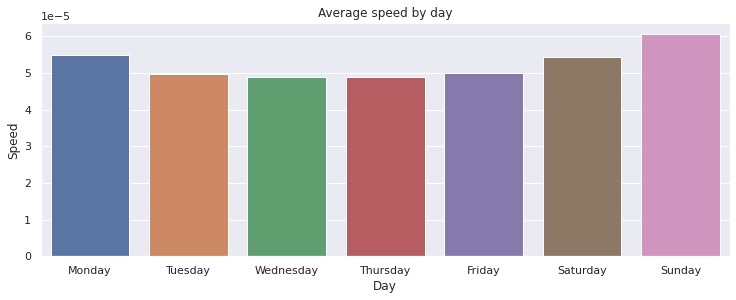

In [129]:
SdaysPlot = sns.barplot(x=list(avgSDays.keys()),
                           y=list(avgSDays.values())).set(title='Average speed by day')

plt.xlabel("Day")
plt.ylabel("Speed")
plt.show(SdaysPlot)

### Average speed by month

In [130]:
avgSMonths = {}
avgSMonths['January'] = 0
avgSMonths['February'] = 0
avgSMonths['March'] = 0
avgSMonths['April'] = 0
avgSMonths['May'] = 0
avgSMonths['June'] = 0
avgSMonths['July'] = 0
avgSMonths['August'] = 0
avgSMonths['September'] = 0
avgSMonths['Octomber'] = 0
avgSMonths['November'] = 0
avgSMonths['December'] = 0

groupedMonths = trainDF.groupby(["pickup_month"])
tempAvgSMonths = dict(groupedMonths["average_speed"].mean())
avgSMonths.update(tempAvgSMonths)

avgSMonths = {k: v for k, v in avgSMonths.items() if v!=0}

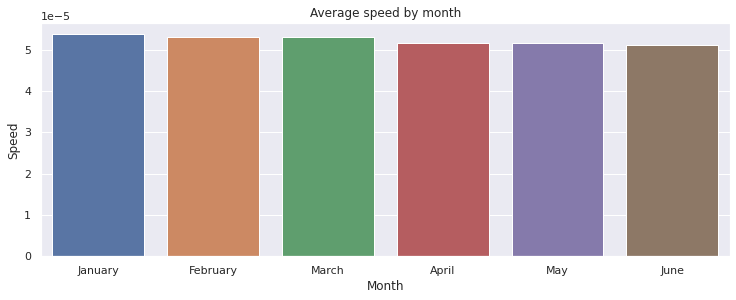

In [131]:
SmonthsPlot = sns.barplot(x=list(avgSMonths.keys()),
                           y=list(avgSMonths.values())).set(title='Average speed by month')

plt.xlabel("Month")
plt.ylabel("Speed")
plt.show(SmonthsPlot)

##*9. Graphs for pickup/dropoff points*

In [132]:
sns.set(rc={'figure.figsize':(12,4)})

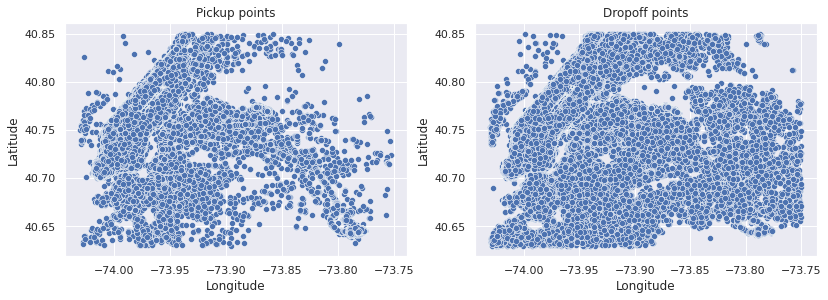

In [133]:
y1_values=list(trainDF["pickup_latitude"])
x1_values=list(trainDF["pickup_longitude"])

y2_values=list(trainDF["dropoff_latitude"])
x2_values=list(trainDF["dropoff_longitude"])

fig, ax =plt.subplots(1,2)

pickupPoints = sns.scatterplot(y=y1_values,
                                   x=x1_values,ax=ax[0]).set(title="Pickup points",
                                                       ylabel = "Latitude",
                                                       xlabel = "Longitude")

dropoffPoints = sns.scatterplot(y=y2_values,
                                   x=x2_values,ax=ax[1]).set(title="Dropoff points",
                                                       ylabel = "Latitude",
                                                       xlabel = "Longitude")                                   

# **Clustering**


> We'll now perform clustering using the k-means algorithm for the pickup points of our train dataset. By using the elbow method we try to compute the best number of clusters to use. We train and plot the results.


In [149]:
pointsList = list(zip(trainDF.pickup_longitude, trainDF.pickup_latitude))

In [150]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pointsList)

In [151]:
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

In [152]:
sns.set(rc={'figure.figsize':(8,4)})


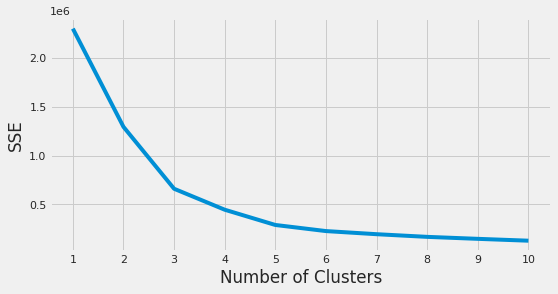

In [153]:
# Plot the data
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [154]:
k = 3
kmeans = KMeans(n_clusters=k).fit(pointsList)

In [155]:
sns.set(rc={'figure.figsize':(5,4)})

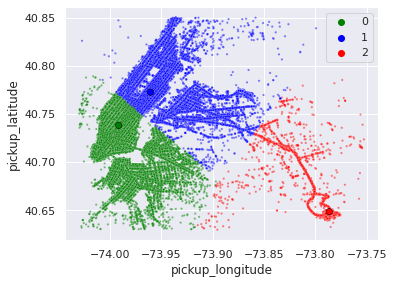

In [156]:
y1_values = trainDF["pickup_latitude"]
x1_values = trainDF["pickup_longitude"]


colors = ['green', 'blue', 'red']
ax = sns.scatterplot(y=y1_values, x=x1_values, hue=kmeans.labels_, palette=colors, alpha=0.5, s=5)
ax = sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                     hue=range(k), palette=colors, s=40, ec='black', legend=False, ax=ax)
plt.show()
